In [53]:
%pip install matplotlib


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [54]:
import numpy as np
from decayangle.lorentz import LorentzTrafo
from decayangle.decay_topology import Topology
from decayangle.config import config as cfg
import matplotlib.pyplot as plt

def make_four_vectors(phi_rf, theta_rf, psi_rf):
    import numpy as np

    # Make sure, the sorting is turned off
    cfg.sorting = "off"

    # Given values
    # Lc -> p K pi
    m1, m2, m3, m0 = 0.93827, 0.493677, 0.139570, 2.28646
    m12 = 2.756020646168232**0.5
    m23 = 1.3743747462964881**0.5

    # Squared masses
    m0sq, m1sq, m2sq, m3sq, m12sq, m23sq = [x**2 for x in [m0, m1, m2, m3, m12, m23]]

    # Källén function
    def Kallen(x, y, z):
        return x**2 + y**2 + z**2 - 2 * (x * y + x * z + y * z)

    # Calculating missing mass squared using momentum conservation
    m31sq = m0sq + m1sq + m2sq + m3sq - m12sq - m23sq

    # Momenta magnitudes
    p1a = np.sqrt(Kallen(m23sq, m1sq, m0sq)) / (2 * m0)
    p2a = np.sqrt(Kallen(m31sq, m2sq, m0sq)) / (2 * m0)

    # Directions and components
    cos_zeta_12_for0_numerator = (m0sq + m1sq - m23sq) * (
        m0sq + m2sq - m31sq
    ) - 2 * m0sq * (m12sq - m1sq - m2sq)
    cos_zeta_12_for0_denominator = np.sqrt(Kallen(m0sq, m2sq, m31sq)) * np.sqrt(
        Kallen(m0sq, m23sq, m1sq)
    )
    cos_zeta_12_for0 = cos_zeta_12_for0_numerator / cos_zeta_12_for0_denominator

    p1z = -p1a
    p2z = -p2a * cos_zeta_12_for0
    p2x = np.sqrt(p2a**2 - p2z**2)
    p3z = -p2z - p1z
    p3x = -p2x

    # Energy calculations based on the relativistic energy-momentum relation
    E1 = np.sqrt(p1z**2 + m1sq)
    E2 = np.sqrt(p2z**2 + p2x**2 + m2sq)
    E3 = np.sqrt(p3z**2 + p3x**2 + m3sq)

    # Vectors
    p1 = np.array([0, 0, p1z, E1])
    p2 = np.array([p2x, 0, p2z, E2])
    p3 = np.array([p3x, 0, p3z, E3])

    # Lorentz transformation
    momenta = {i: p for i, p in zip([1, 2, 3], [p1, p2, p3])}
    tree1 = Topology(root=0, decay_topology=((2, 3), 1))
    
    rotation = LorentzTrafo(0, 0, 0, phi_rf, theta_rf, psi_rf)
    
    momenta_23_rotated = tree1.root.transform(rotation, momenta)
    return momenta_23_rotated

In [67]:
N = 1000
x = np.linspace(1e-5, np.pi - 1e-5, N)
y = np.linspace(-np.pi + 1e-5, np.pi - 1e-5, N)

X, Y = np.meshgrid(x, y)
momenta_23_rotated = make_four_vectors(1.4, X, Y)

tree1 = Topology(root=0, decay_topology=((2, 3), 1))
tree2 = Topology(root=0, decay_topology=((3, 1), 2))
tree3 = Topology(root=0, decay_topology=((1, 2), 3))

result_full = tree1.relative_wigner_angles(tree3, momenta_23_rotated)
result_psi = result_full[1].psi_rf
result_phi = result_full[1].phi_rf
result_theta = result_full[1].theta_rf
result = result_psi + result_phi

def fmod_4(val):
    return np.fmod(val/np.pi,4)



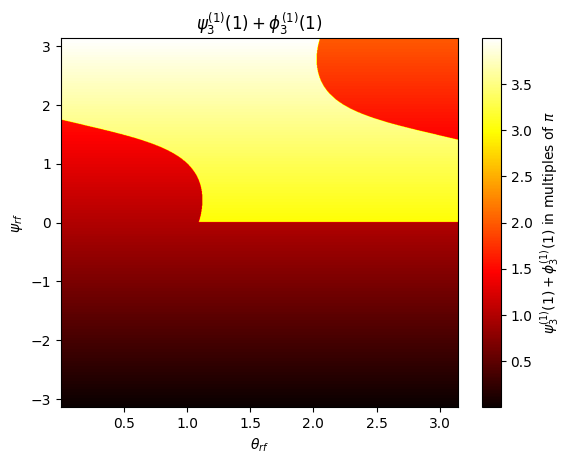

In [68]:
def fmod_4(val):
    return np.fmod(val/np.pi + 4,4)

img = plt.imshow(fmod_4(result), cmap='hot', origin='lower',
                 extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')

plt.colorbar(label=r"$\psi_{3}^{(1)}(1) + \phi_{3}^{(1)}(1)$ in multiples of $\pi$")
plt.xlabel(r'$\theta_{rf}$')
plt.ylabel(r'$\psi_{rf}$')
plt.title(r"$\psi_{3}^{(1)}(1) + \phi_{3}^{(1)}(1)$")
plt.savefig('test.png', dpi = 1200)
plt.show()
plt.close('all')

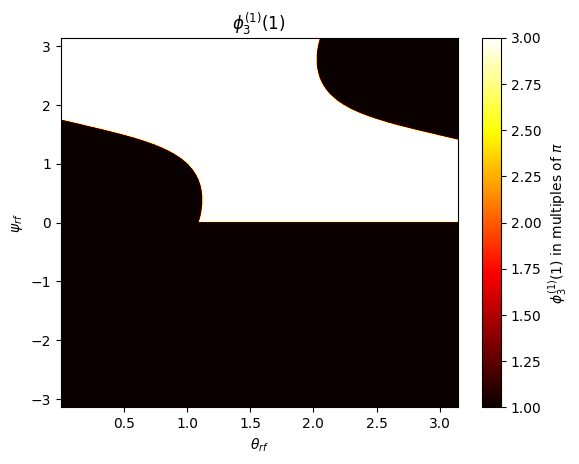

In [69]:
img = plt.imshow(np.fmod(result_phi/np.pi +4, 4), cmap='hot', origin='lower',
                 extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')

plt.colorbar(label=r"$\phi_{3}^{(1)}(1)$ in multiples of $\pi$")
plt.xlabel(r'$\theta_{rf}$')
plt.ylabel(r'$\psi_{rf}$')
plt.title(r"$\phi_{3}^{(1)}(1)$")
plt.savefig('test_phi.png', dpi = 1200)
plt.show()
plt.close('all')

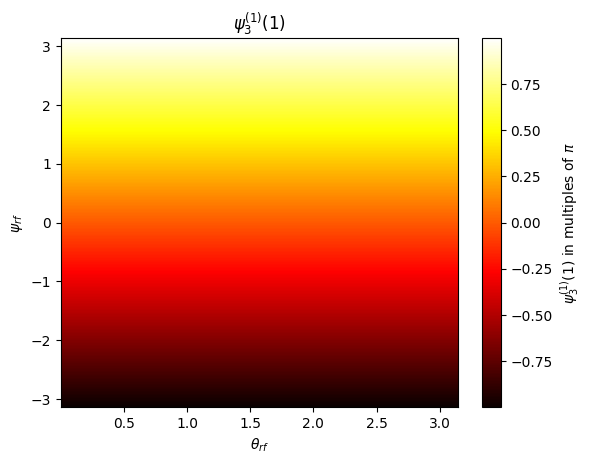

In [70]:
img = plt.imshow(result_psi/np.pi, cmap='hot', origin='lower',
                 extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')

plt.colorbar(label=r"$\psi_{3}^{(1)}(1)$ in multiples of $\pi$")
plt.xlabel(r'$\theta_{rf}$')
plt.ylabel(r'$\psi_{rf}$')
plt.title(r"$\psi_{3}^{(1)}(1)$")
plt.savefig('test_psi.png', dpi = 1200)
plt.show()
plt.close('all')

Lets see how the different rotations

In [117]:
def plot_path(convention, include=[1,2,3], color_info = False, cm=plt.cm.viridis, reference=True):
    N = 1000
    t = np.linspace(-0.5,1.5,N)
    x = np.pi/2 + np.pi/2*np.exp(1j*np.pi*t)

    t = np.linspace(0,1, N)
    theta, psi = np.real(x), 2*np.imag(x)
    momenta_23_rotated = make_four_vectors(0.7, theta, psi)

    tree1 = Topology(root=0, decay_topology=((2, 3), 1))
    tree2 = Topology(root=0, decay_topology=((3, 1), 2))
    tree3 = Topology(root=0, decay_topology=((1, 2), 3))

    result_full1 = tree1.helicity_angles(momenta_23_rotated, convention=convention)
    result_full2 = tree2.helicity_angles(momenta_23_rotated, convention=convention)
    result_full3 = tree3.helicity_angles(momenta_23_rotated, convention=convention)

    result_full3.keys()
    
    def plot_color_segments(y,x, fmt=None, color=None, label=None):
        for i, (x_, y_, c) in enumerate(zip(x[:-1],y[:-1], color[:-1])):
            if fmt is not None:
                plt.plot([x_, x[i+1]], [y_, y[i+1]], fmt, color=c)
            else:
                plt.plot([x_, x[i+1]], [y_, y[i+1]], color=c)
        plt.plot(x[0], y[0], color=color[0], label=label)

    if 1 in include:
        if color_info:
            plot_color_segments(result_full1[((2, 3), 1)].psi_rf, result_full1[((2, 3), 1)].theta_rf,  color=cm(t), label=r"$(\phi_1, \theta_1)$")
            # plot_color_segments(result_full1[(2, 3)].psi_rf, result_full1[(2, 3)].theta_rf, color=cm(t), label=r"$(\psi_{1}, \theta_{23})")
            # plt.scatter(result_full1[((2, 3), 1)].psi_rf, result_full1[((2, 3), 1)].theta_rf, label=r"$(\phi_1, \theta_1)$", color=cm(t))
            # plt.scatter(result_full1[(2, 3)].psi_rf, result_full1[(2, 3)].theta_rf, label=r"$(\psi_{1}, \theta_{23})$", color=cm(t))
        else:
            plt.plot(result_full1[((2, 3), 1)].psi_rf, result_full1[((2, 3), 1)].theta_rf, "+", label=r"$(\phi_1, \theta_1)$", color="black")
            # plt.plot(result_full1[(2, 3)].psi_rf, result_full1[(2, 3)].theta_rf,"+", label=r"$(\psi_{1}, \theta_{23})$", color="grey")

    if 2 in include:
        if color_info:
            plot_color_segments(result_full2[((3, 1), 2)].psi_rf, result_full2[((3, 1), 2)].theta_rf, color=cm(t), label=r"$(\phi_2, \theta_2)")
            # plot_color_segments(result_full2[(3, 1)].psi_rf, result_full2[(3, 1)].theta_rf, color=cm(t), label=r"$(\psi_{2}, \theta_{31})")
            # plt.scatter(result_full2[((3, 1), 2)].psi_rf, result_full2[((3, 1), 2)].theta_rf,label=r"$(\phi_2, \theta_2)$", color=cm(t))
            # plt.scatter(result_full2[(3, 1)].psi_rf, result_full2[(3, 1)].theta_rf,label=r"$(\psi_{2}, \theta_{31})$", color=cm(t))
        else:
            plt.plot(result_full2[((3, 1), 2)].psi_rf, result_full2[((3, 1), 2)].theta_rf, label=r"$(\psi_2, \theta_2)$", color="blue")
            # plt.plot(result_full2[(3, 1)].psi_rf, result_full2[(3, 1)].theta_rf, label=r"$(\psi_{2}, \theta_{31})$", color="purple")

    if 3 in include:
        if color_info:
            plot_color_segments(result_full3[((1, 2), 3)].psi_rf, result_full3[((1, 2), 3)].theta_rf, color=cm(t), label=r"$(\phi_3, \theta_3)$")
            plot_color_segments(result_full3[(1, 2)].psi_rf, result_full3[(1, 2)].theta_rf, color=cm(t), label=r"$(\psi_{3}, \theta_{12})")
            # plt.scatter(result_full3[((1, 2), 3)].psi_rf, result_full3[((1, 2), 3)].theta_rf, label=r"$(\phi_3, \theta_3)$", color=cm(t))
            # plt.scatter(result_full3[(1, 2)].psi_rf, result_full3[(1, 2)].theta_rf, label=r"$(\psi_{3}, \theta_{12})$", color=cm(t))
        else:
            plt.plot(result_full3[((1, 2), 3)].psi_rf, result_full3[((1, 2), 3)].theta_rf, "--", label=r"$(\psi_3, \theta_3)$", color="red")
            # plt.plot(result_full3[(1, 2)].psi_rf, result_full3[(1, 2)].theta_rf, "--",label=r"$(\psi_{3}, \theta_{12})$", color="orange")

    plt.legend()
    plt.xlabel(r'$\psi$')

    plt.ylabel(r'$\theta$')
    plt.savefig("angle_path1.png", dpi = 800)
    plt.show()
    if reference:
        img = plt.imshow(np.fmod(result_phi/np.pi +4, 4), cmap='hot', origin='lower',
                 extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')

        plt.colorbar(label=r"$\phi_{3}^{(1)}(1)$ in multiples of $\pi$")
        plt.xlabel(r'$\theta_{rf}$')
        plt.ylabel(r'$\psi_{rf}$')
        plt.title(r"$\phi_{3}^{(1)}(1)$")
        if color_info:
            plot_color_segments(psi,theta ,color=cm(t))
            # plt.colorbar(label="t", min=-0.5, max=1.5)
        else:
            plt.plot(psi,theta,"." ,color="black")
        plt.savefig("angle_path2.png", dpi = 800)
        plt.show()
    
 

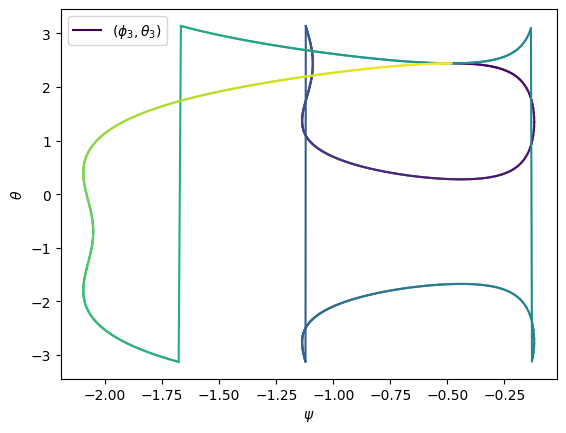

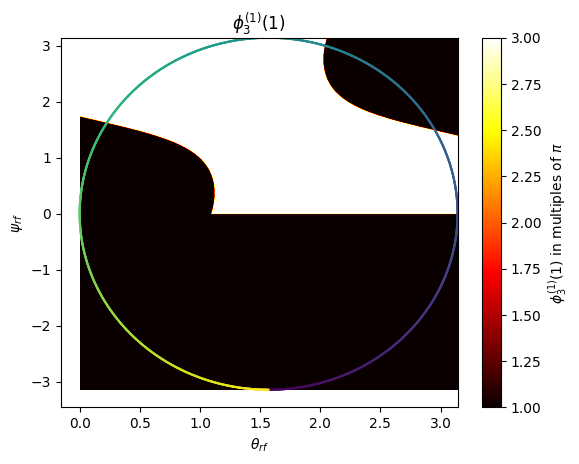

In [114]:
plot_path("helicity", include=[3], color_info=True)

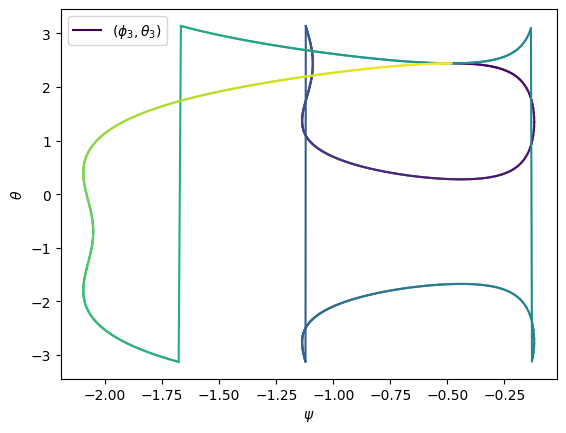

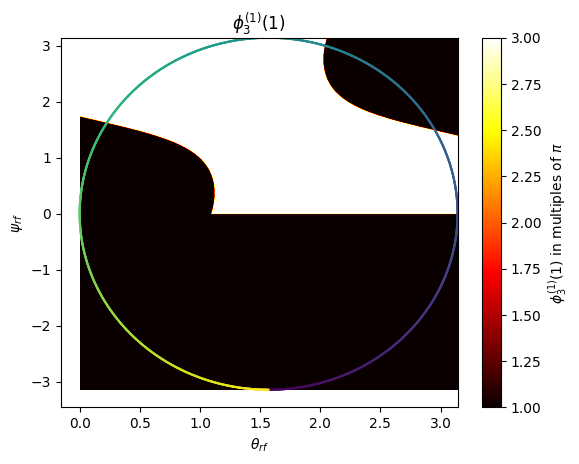

In [115]:
plot_path("minus_phi", include=[3], color_info=True)

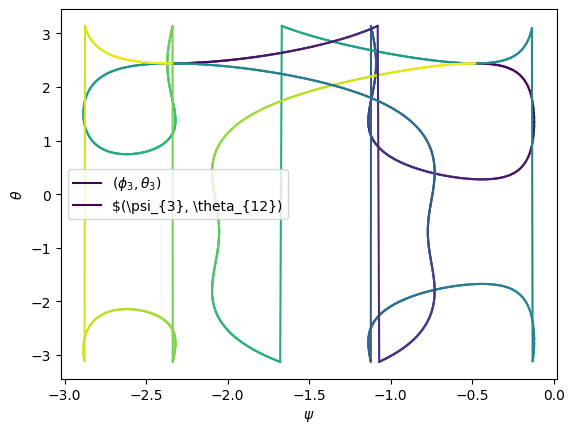

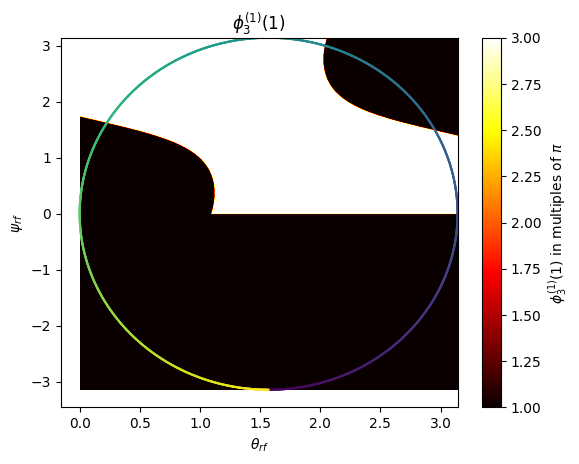

In [118]:
plot_path("canonical", include=[3], color_info=True)